In [3]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

GBDT 在 spark 中的实现简介
========================

分析用的代码版本信息:

```sh
~/W/spark ❯❯❯ git log -n 1
commit 2eedc00b04ef8ca771ff64c4f834c25f835f5f44
Author: Wenchen Fan <wenchen@databricks.com>
Date:   Mon Aug 1 17:54:41 2016 -0700

    [SPARK-16828][SQL] remove MaxOf and MinOf

    ## What changes were proposed in this pull request?

    These 2 expressions are not needed anymore after we have `Greatest` and `Least`. This PR removes them and related tests.

    ## How was this patch tested?

    N/A

    Author: Wenchen Fan <wenchen@databricks.com>

    Closes #14434 from cloud-fan/minor1.
```

### 0. 总纲 

下图是主要涉及到的类之间的关系：

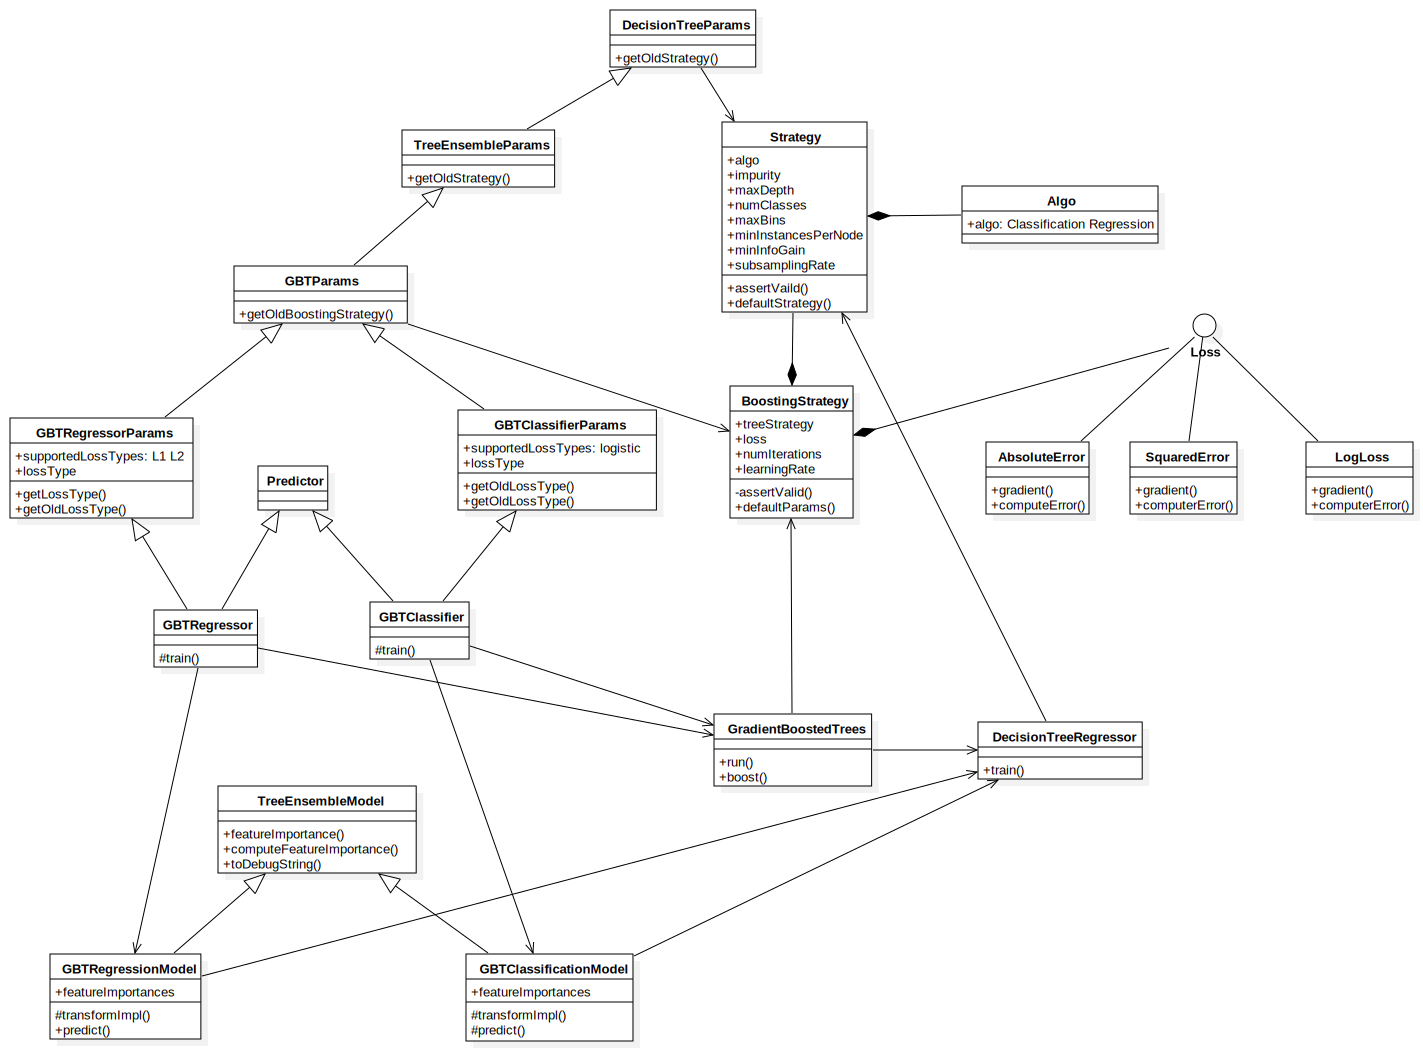

In [3]:
SVG("./res/uml/gbdt_spark.svg")

spark 封装得比较细，一眼看去各种类，乱花迷眼。但其实因为拆分得当，厘清关系是比较容易的，较高的抽象层次也让代码非常易读。

为了便于逻辑叙述，我们按调用顺序由顶至下地，分别介绍各个涉及类的大致作用。

+ 训练调用顺序：
   1. `GBTRegressor.train` 和 `GBTClassifier.train` 是训练方法的入口。     
      因为二分类问题会转换成 $\{-1, 1\}$ 回归问题，所以两个类差别在参数上，调用路径是一致的。
   2. `GradientboostedTrees` 通过 `run` 启动 `boost` 方法开始训练，这是 GBDT 的算法主体代码逻辑。
   3. 训练中的参数都由 `BoostingStrategy` 控制，它主要的构成是：
      + 损失函数类 `Loss`，具体实现是 logstic, L1, L2 三种。
      + 树生成参数 `Strategy` 指导 `DecisionTreeRegressor` 进行拟合。
   4. 训练后组建 `GBTRegressionModel` 或 `GBTClassificationModel`。
      
+ 预测调用顺序    
  预测比较简单，`GBT*Model` 类按权值加总 `DecisionTreeRegressor` 结果即可。      
  另外，`GBT*Model.featureImportances` 是个有意思的变量，它用于评估特征的重要度，主要由 `TreeEnsembleModel` 计算，后面会细讲。
  
因为这里很多类只是起封装作用，我们只会介绍涉及到 GBDT 算法实现的具体类和函数，不会对整个工程面面俱到。另外，决策树在 spark 中的实现会专门分析，本文不深入。

### 1. 训练算法实现 `GradientBoostedTrees.boost` 

`GradientBoostedTrees.boost` 是论文 J.H. Friedman.  "Stochastic Gradient Boosting."  1999.  的训练算法实现，而非 TreeBoost。具体算法本身的原理及细节会专门发文讲解，这里直接给算法描述:

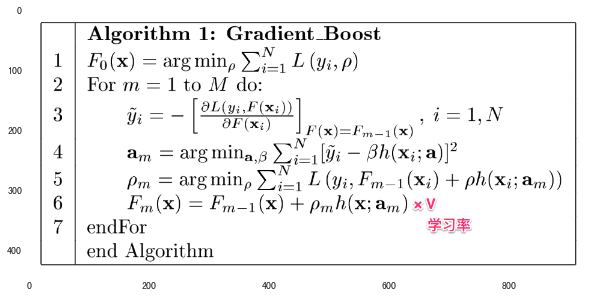

In [5]:
show_image("./res/gbdt.png", figsize=(10,5))

上图来源于论文 Friedman - Greedy function approximation: A gradient boosting machine，第6行引入了学习率控制过拟合。 

下面是 spark 中实现代码：

```Scala
243   def boost(
244 //+--  5 lines: input: RDD[LabeledPoint],-----------------------------------------------------
249 //+--  7 lines: val timer = new TimeTracker()-------------------------------------------------
256     val numIterations = boostingStrategy.numIterations
257     val baseLearners = new Array[DecisionTreeRegressionModel](numIterations)
258     val baseLearnerWeights = new Array[Double](numIterations)
259     val loss = boostingStrategy.loss
260     val learningRate = boostingStrategy.learningRate
261     // Prepare strategy for individual trees, which use regression with variance impurity.
262     val treeStrategy = boostingStrategy.treeStrategy.copy
263     val validationTol = boostingStrategy.validationTol
264     treeStrategy.algo = OldAlgo.Regression
265     treeStrategy.impurity = OldVariance
266     treeStrategy.assertValid()
267
268 //+-- 20 lines: Cache input-------------------------------------------------------------------
288     // Initialize tree
289     timer.start("building tree 0")
290     val firstTree = new DecisionTreeRegressor().setSeed(seed)
291     val firstTreeModel = firstTree.train(input, treeStrategy)
292     val firstTreeWeight = 1.0
293     baseLearners(0) = firstTreeModel
294     baseLearnerWeights(0) = firstTreeWeight
295
296     var predError: RDD[(Double, Double)] =
297       computeInitialPredictionAndError(input, firstTreeWeight, firstTreeModel, loss)
298 //+-- 11 lines: predErrorCheckpointer.update(predError)---------------------------------------
309
310     var m = 1
311     var doneLearning = false
312     while (m < numIterations && !doneLearning) {
313       // Update data with pseudo-residuals
314       val data = predError.zip(input).map { case ((pred, _), point) =>
315         LabeledPoint(-loss.gradient(pred, point.label), point.features)
316       }
317
318 //+--  4 lines: timer.start(s"building tree $m")----------------------------------------------
322       val dt = new DecisionTreeRegressor().setSeed(seed + m)
323       val model = dt.train(data, treeStrategy)
324 //+--  2 lines: timer.stop(s"building tree $m")-----------------------------------------------
326       baseLearners(m) = model
327       // Note: The setting of baseLearnerWeights is incorrect for losses other than SquaredError.
328       //       Technically, the weight should be optimized for the particular loss.
329       //       However, the behavior should be reasonable, though not optimal.
330       baseLearnerWeights(m) = learningRate
331
332       predError = updatePredictionError(
333         input, predError, baseLearnerWeights(m), baseLearners(m), loss)
334 //+-- 21 lines: predErrorCheckpointer.update(predError)---------------------------------------
355       m += 1
356     }
357 //+-- 15 lines: timer.stop("total")-----------------------------------------------------------
372   }
```

接下来，我们将代码和算法步骤联系起来:

+ 算法第一行，基准模型，对应 290L-294L;

+ 算法第二行，结束条件，对应 312L;

+ 算法第三行，损失函数的梯度，对应 315L;

+ 算法第四行，树模型训练，对应 323L;

+ 算法第五行，权重计算，对应 330L;

+ 算法第六行，加入新训练的树，对应 332L-333L.

很容易注意到，330L 对权重计算的实现很奇怪，将学习率直接作为树的权重值。对应的代码注释也说明此实现有问题，但不是很直白。用我的理解，它的实际意图应该是如此考虑的：

1. $\beta h(x_i; a)$ 是树模型的训练。决策树生成时用的 impurity 方法是 265L 的 OldVariance，追踪过去可以看到 $\beta = 1$。

2. 对于损失函数 L2，它的 $\rho_m = \beta_m = 1$，推导很简单，见论文 Friedman : Greedy function approximation: A gradient boosting machine. 章节 4.1 Least Squares regression。

3. 因为 $\rho = 1$，而算法第六行，要乘的权重 $\rho v = v$。

这就是注释里说只对 SquaredError （即 L2）权重是正确的。